# Protocols with steps and ramps

Myokit's [Protocol](https://myokit.readthedocs.io/api_simulations/Protocol.html) class can be used to define step protocols, that are piecewise constants. But what if we want to create ramps as well?

This example shows how this can be achieved by combining a step protocol with ramps encoded in the model equations.

We'll try to copy the following protocol:

odict_keys(['time', 'voltage'])


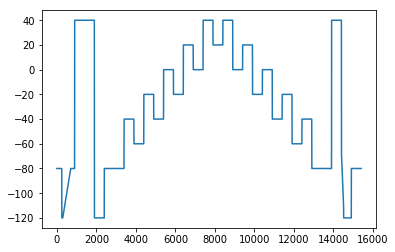

In [2]:
import matplotlib.pyplot as plt
import myokit
import numpy as np

# Load a CSV file
d1 = myokit.DataLog.load_csv('staircase-ramp.csv')

# Convert Python lists to NumPy arrays
d1 = d1.npview()

# Convert time to ms
d1['time'] *= 1000

# Get time just after protocol is finished
tmax = d1['time'][-1] + 1

# Show the contents
print(d1.keys())

plt.figure()
plt.plot(d1.time(), d1['voltage'])
plt.show()

As a first approximation, we'll load a Myokit protocol that implements the steps:

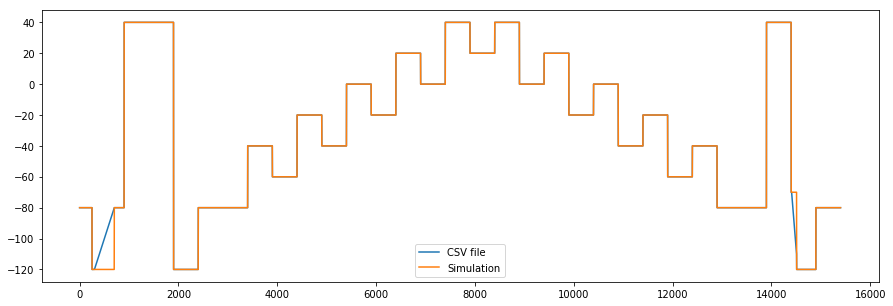

In [3]:
m = myokit.load_model('beattie-2017-ikr-hh.mmt')
p = myokit.load_protocol('staircase-protocol-ramp.mmt')
s = myokit.Simulation(m, p)

d2 = s.run(tmax+10, log_times=d1.time())

plt.figure(figsize=(15, 5))
plt.plot(d1.time(), d1['voltage'], label='CSV file')
plt.plot(d2.time(), d2['membrane.V'], label='Simulation')
plt.legend()
plt.show()

Next, we add in the ramps.

First we define equations for both ramps.

### Ramp 1

$V_1(t=300) = -120$

$V_1(t=700) = -80$

$V_1 = -120 + (t - 300) * 40 / 400 = -150 + t / 10$


### Ramp 2

$V_1(t=14410) = -70$

$V_1(t=14510) = -110$

$V_2 = -70 + (t - 14410) * -40 / 100 = 5694 - 0.4 t$

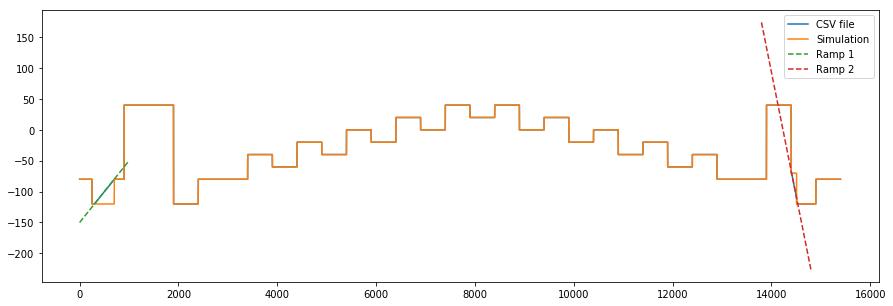

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(d1.time(), d1['voltage'], label='CSV file')
plt.plot(d2.time(), d2['membrane.V'], label='Simulation')

t1 = np.linspace(0, 1000, 1000)
v1 = -150 + 0.1 * t1

t2 = np.linspace(13800, 14800, 1000)
v2 = 5694 - 0.4 * t2

plt.plot(t1, v1, '--', label='Ramp 1')
plt.plot(t2, v2, '--', label='Ramp 2')

plt.legend()
plt.show()

Now we'll add these ramps into the model, by programmatically modifying the `membrane` component:

In [5]:
print(m.get('membrane').code())

[membrane]
V = -80 [mV] bind pace




We'll replace this by something of the form:

\begin{align}
vp  &= \text{step protocol} \\
v1 &= -150 + 0.1 * t \\
v2 &= 5694 - 0.4 * t \\
V  &= \begin{cases}
    v1 & \mbox{ if } 300 \leq t < 700 \\
    v2 & \mbox{ if } 14410 \leq t < 14510 \\
    vp  & \mbox{ otherwise} \\
\end{cases}
\end{align}

In [6]:
# Load the model
m = myokit.load_model('beattie-2017-ikr-hh.mmt')

# Get the membrane component
c = m.get('membrane')

# Get the voltage variable, and remove its binding to `pace`
v = c.get('V')
v.set_binding(None)

# Add a v1 variable
v1 = c.add_variable('v1')
v1.set_rhs('-150 + 0.1 * engine.time')

# Add a v2 variable
v2 = c.add_variable('v2')
v2.set_rhs('5694 - 0.4 * engine.time')

# Add a p variable
vp = c.add_variable('vp')
vp.set_rhs(0)
vp.set_binding('pace')

# Set a new right-hand side equation for V
v.set_rhs('piecewise((engine.time >= 300 and engine.time < 700), v1, (engine.time >=14410 and engine.time < 14510), v2, vp)')


In [7]:
print(c.code())

[membrane]
V = piecewise(engine.time >= 300 and engine.time < 700, v1, engine.time >= 14410 and engine.time < 14510, v2, vp)
v1 = -150 + 0.1 * engine.time
v2 = 5694 - 0.4 * engine.time
vp = 0 bind pace




We now run a simulation with the updated model and compare:

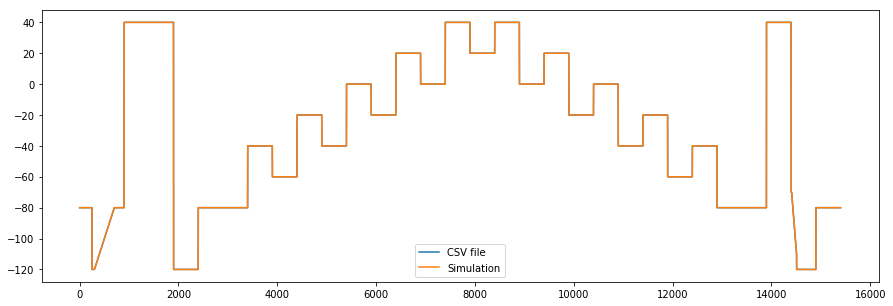

In [8]:
s = myokit.Simulation(m, p)

d2 = s.run(tmax+10, log_times=d1.time())

plt.figure(figsize=(15, 5))
plt.plot(d1.time(), d1['voltage'], label='CSV file')
plt.plot(d2.time(), d2['membrane.V'], label='Simulation')
plt.legend()
plt.show()

Just to be sure, we inspect the difference:

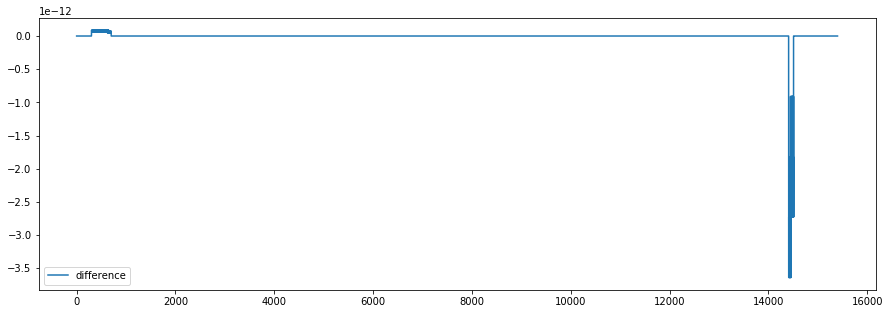

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(d1.time(), d1['voltage'] - d2['membrane.V'], label='difference')
plt.legend()
plt.show()

So, we have matched the protocol in the CSV file very closely!